In [1]:
import os
from tqdm import tqdm
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from natsort import natsorted
from scipy.signal import find_peaks

In [2]:
pipe_path = "/home/dais01/Preprocess/data/Data/Raw_Data_png/202212/ALL/9.53/22G017-09-002"
image_list = glob(os.path.join(pipe_path, "*.png"))
image_list = natsorted(image_list)
merge_image = []
margin = 0

image_shape = cv2.imread(image_list[0], cv2.IMREAD_GRAYSCALE).shape

for i in tqdm(range(len(image_list))):
    image = cv2.imread(image_list[i], cv2.IMREAD_GRAYSCALE)
    #image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    merge_image.append(image)
    
merge_image = np.concatenate(merge_image, axis=1)
merge_image_shape = merge_image.shape
center_x = merge_image_shape[1] // 2


  0%|          | 0/107 [00:00<?, ?it/s]

100%|██████████| 107/107 [00:00<00:00, 137.24it/s]


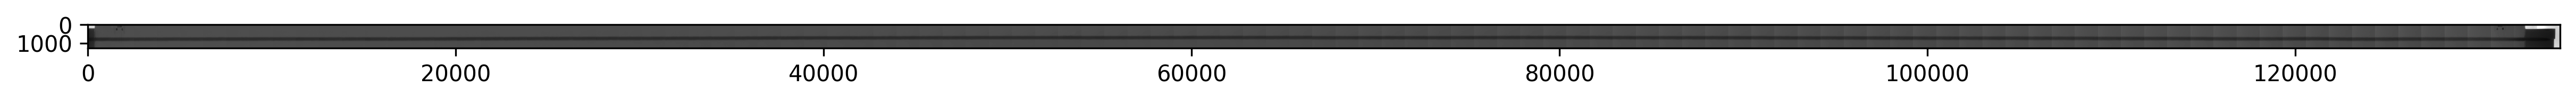

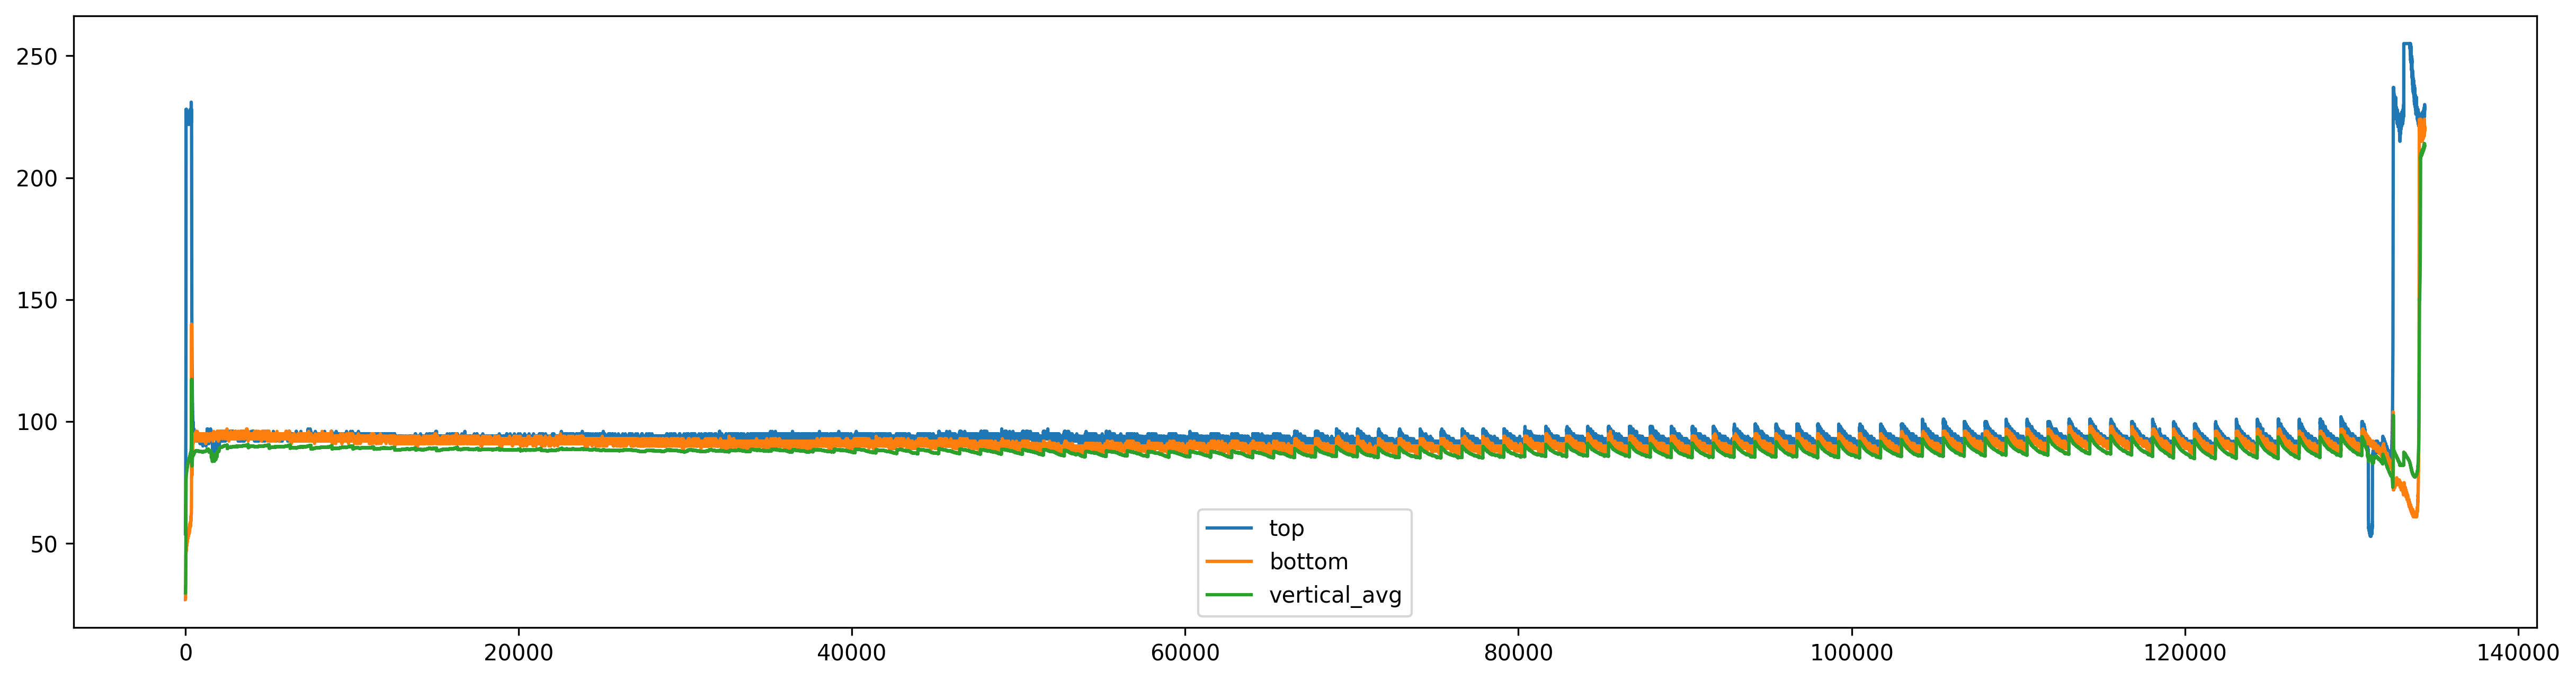

In [3]:
plt.figure(figsize=(20, 5), dpi=300)
plt.imshow(merge_image, cmap='gray')

top_merge_image = merge_image[0, :]
bottom_merge_image = merge_image[-1, :]
vertical_avg = np.mean(merge_image, axis=0)

argmax_top_1 = np.argmax(top_merge_image[center_x:])
argmax_bottom_1 = np.argmax(bottom_merge_image[center_x:])
argmax_vertical_1 = np.argmax(vertical_avg[center_x:])
argmax_top_2 = np.argmax(top_merge_image[:center_x])
argmax_bottom_2 = np.argmax(bottom_merge_image[:center_x])
argmax_vertical_2 = np.argmax(vertical_avg[:center_x])

#1차 검출
min_edge = np.max([argmax_top_2, argmax_bottom_2, argmax_vertical_2]) + margin
max_edge = merge_image_shape[1] - (np.min([argmax_top_1, argmax_bottom_1, argmax_vertical_1]) + center_x) + margin

min_index = min_edge // 1256
max_index = max_edge // 1256

plt.figure(figsize=(20, 5), dpi=300)
plt.plot(top_merge_image)
plt.plot(bottom_merge_image)
plt.plot(vertical_avg)
plt.legend(['top', 'bottom', 'vertical_avg'])

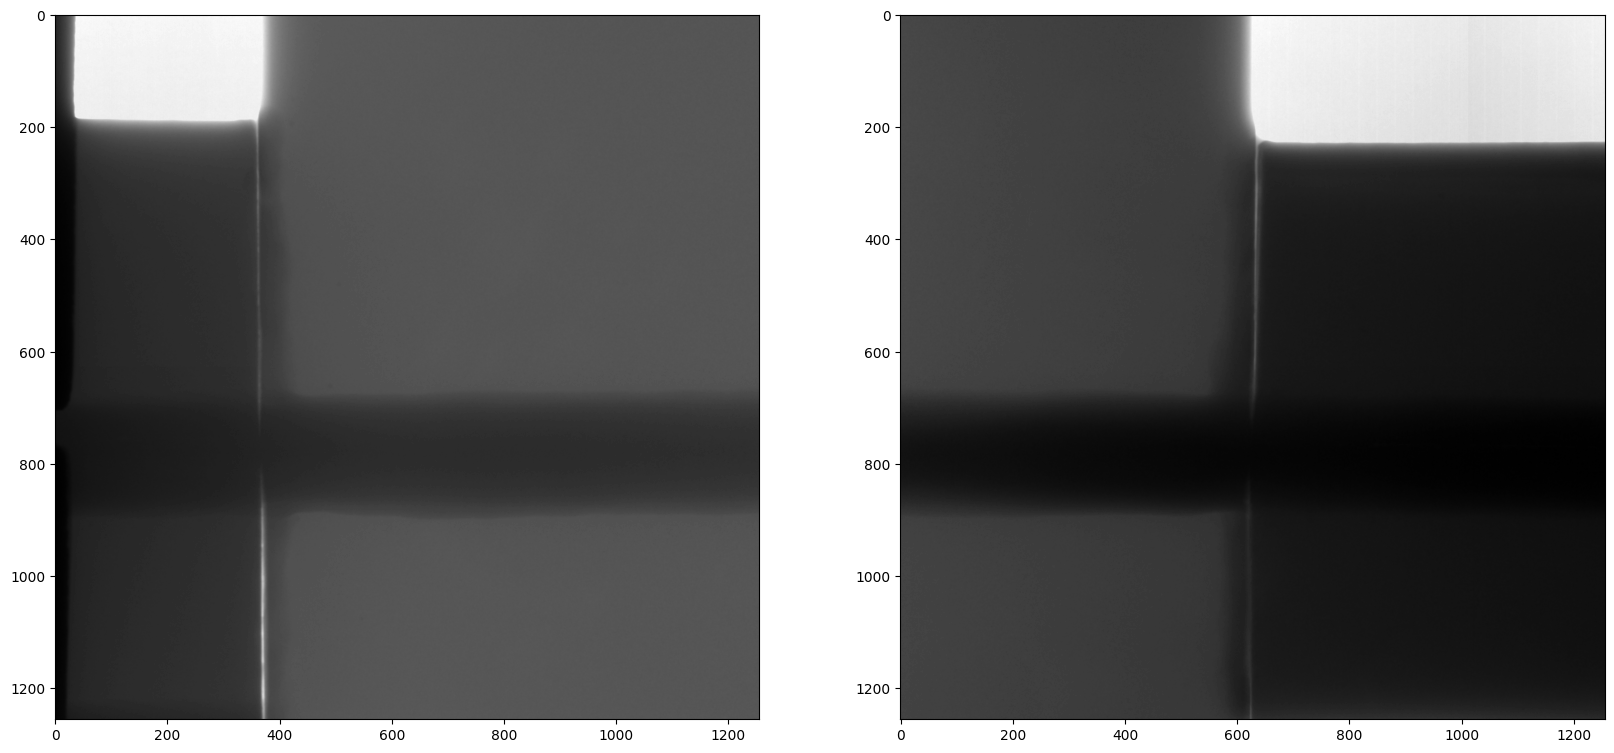

In [4]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_list[min_index], cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(image_list[-(max_index+1)], cv2.IMREAD_GRAYSCALE), cmap='gray')

left_peaks: [367]
right_peaks: [632]


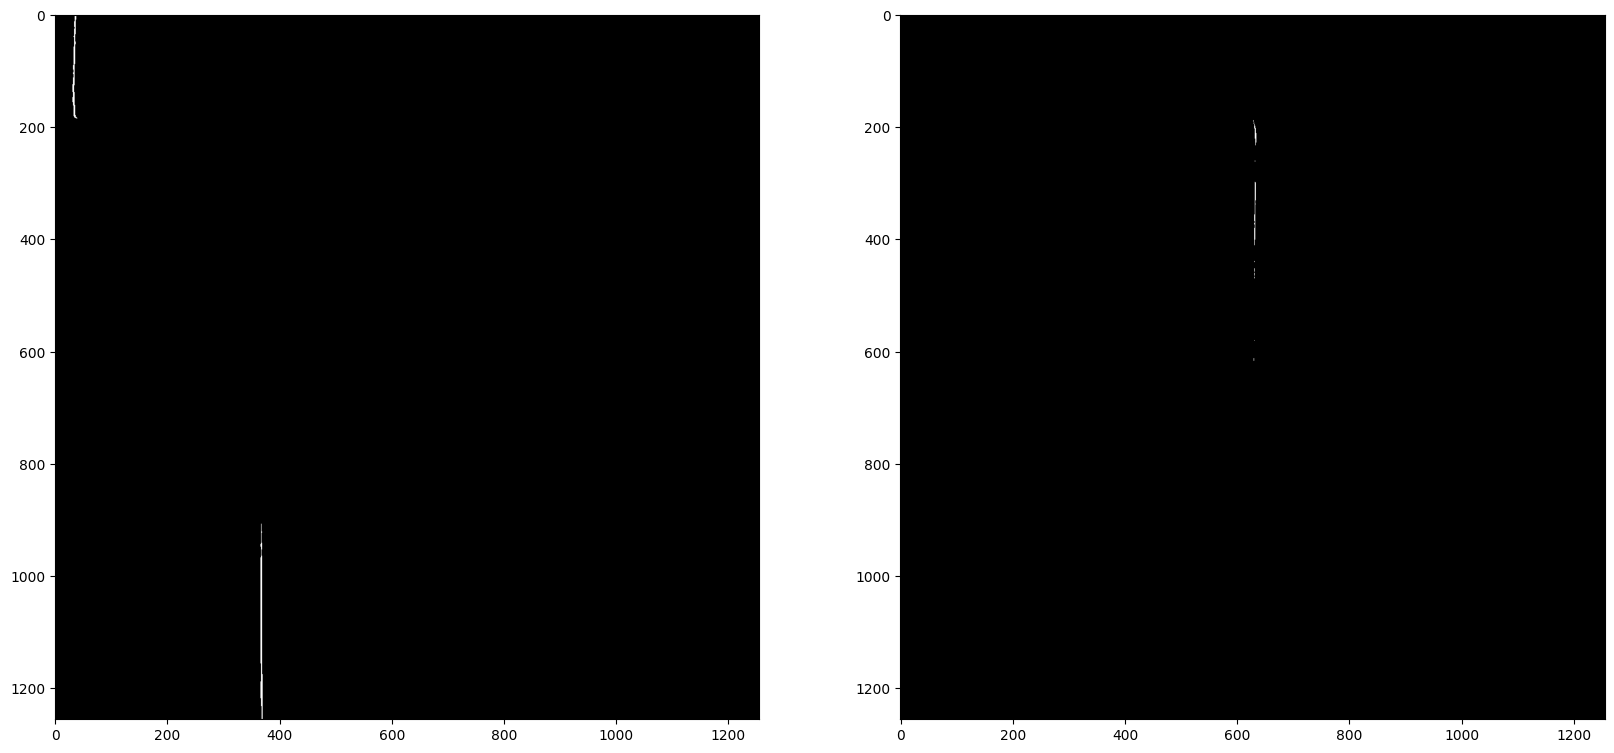

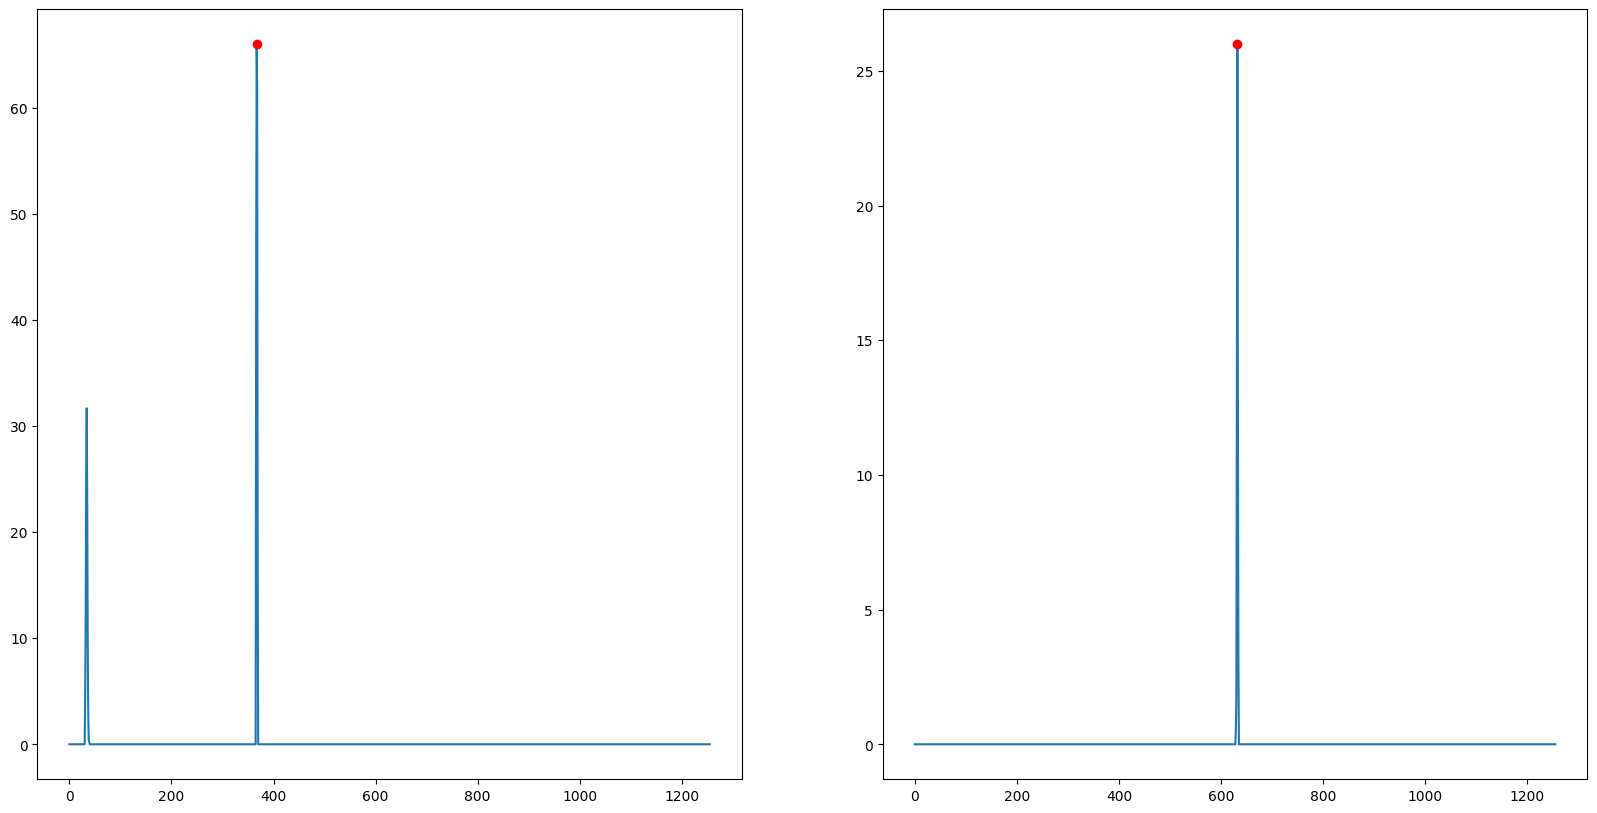

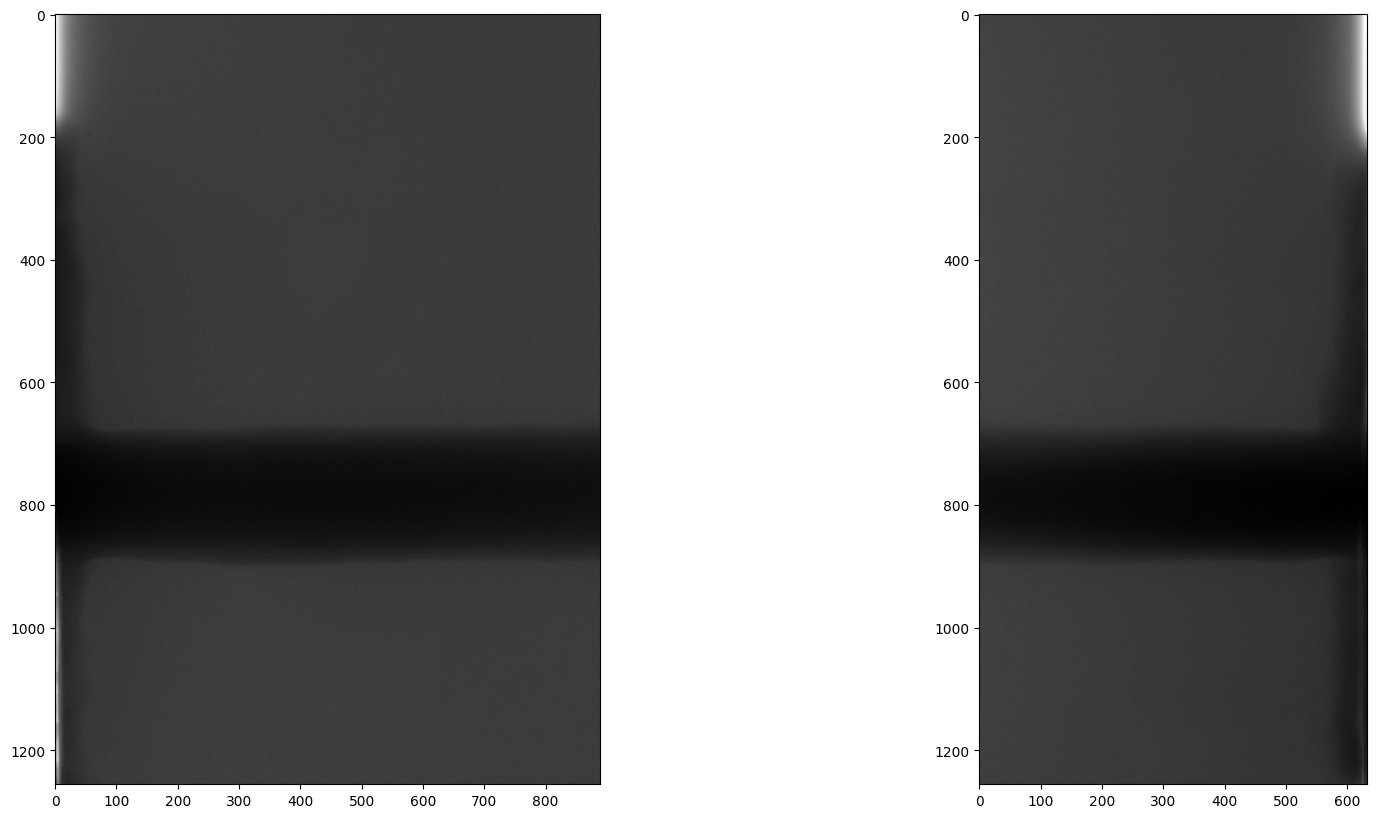

In [5]:
left_endtab = cv2.imread(image_list[min_index], cv2.IMREAD_GRAYSCALE)
right_endtab = cv2.imread(image_list[-(max_index+1)], cv2.IMREAD_GRAYSCALE)


#세로선 찾기. 소벨 마스크를 사용하여 세로선을 찾는다.
left_endtab_sobel = cv2.Sobel(left_endtab, cv2.CV_8U, 1, 0, ksize=3)
right_endtab_sobel = cv2.Sobel(right_endtab, cv2.CV_8U, 1, 0, ksize=3)

left_endtab_pre = cv2.normalize(left_endtab_sobel, None, 0, 1, cv2.NORM_MINMAX)
right_endtab_pre = cv2.normalize(right_endtab_sobel, None, 0, 1, cv2.NORM_MINMAX)
left_endtab_pre = cv2.normalize(left_endtab_pre, None, 0, 255, cv2.NORM_MINMAX)
right_endtab_pre = cv2.normalize(right_endtab_pre, None, 0, 255, cv2.NORM_MINMAX)



plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(left_endtab_pre, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(right_endtab_pre, cmap='gray')

#세로선을 찾아서 세로선의 위치를 찾는다.
left_endtab_pre_mean = np.mean(left_endtab_pre, axis=0)
right_endtab_pre_mean = np.mean(right_endtab_pre, axis=0)

left_peaks, _ = find_peaks(left_endtab_pre_mean, height=3, distance=1000)
right_peaks, _ = find_peaks(right_endtab_pre_mean, height=3, distance=1000)

print(f"left_peaks: {left_peaks}")
print(f"right_peaks: {right_peaks}")


plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(left_endtab_pre_mean)
plt.plot(left_peaks, left_endtab_pre_mean[left_peaks], 'ro')
plt.subplot(1, 2, 2)
plt.plot(right_endtab_pre_mean)
plt.plot(right_peaks, right_endtab_pre_mean[right_peaks], 'ro')

#세로선의 위치를 기준으로 왼쪽 오른쪽을 나눈다.
left_endtab = left_endtab[:, left_peaks[0]:]
right_endtab = right_endtab[:, :right_peaks[0]]
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(left_endtab, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(right_endtab, cmap='gray')
    

left_endtab_index: 0
right_endtab_index: -2
left_endtab_peak: 367
right_endtab_peak: 632
left_endtab_x: 367
right_endtab_x: -1880


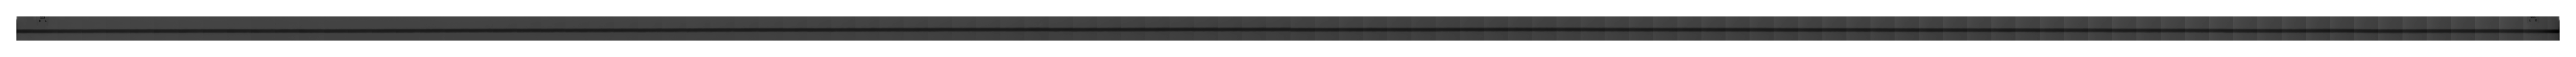

In [7]:
#final
left_endtab_index = min_index #이미지에서 min_index에 해당하는 이미지가 left_endtab이다.
right_endtab_index = -(max_index+1) #이미지에서 max_index에 해당하는 이미지가 right_endtab이다.
left_endtab_peak = left_peaks[0] #left_endtab의 x좌표
right_endtab_peak = right_peaks[0] #right_endtab의 x좌표
left_endtab_x = left_endtab_index * 1256 + left_endtab_peak #좌측에서 잘라낼 픽셀값
right_endtab_x = ((right_endtab_index) * 1256 + right_endtab_peak) #우측에서 잘라낼 픽셀값

print(f"left_endtab_index: {left_endtab_index}")
print(f"right_endtab_index: {right_endtab_index}")
print(f"left_endtab_peak: {left_endtab_peak}")
print(f"right_endtab_peak: {right_endtab_peak}")
print(f"left_endtab_x: {left_endtab_x}")
print(f"right_endtab_x: {right_endtab_x}")

cutted_image = merge_image[:, left_endtab_x:right_endtab_x]
plt.figure(figsize=(20, 10), dpi=300)
plt.imshow(cutted_image, cmap='gray')
plt.show()

In [13]:
def cut_endtab(dir):
    image_list = glob(os.path.join(dir, "*.png"))
    image_list = natsorted(image_list)
    
    merge_image = []
    for i in tqdm(range(len(image_list))):
        image = cv2.imread(image_list[i], cv2.IMREAD_GRAYSCALE)
        #image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        merge_image.append(image)

    merge_image = np.concatenate(merge_image, axis=1)
    merge_image_shape = merge_image.shape
    center_x = merge_image_shape[1] // 2
    top_merge_image = merge_image[0, :]
    bottom_merge_image = merge_image[-1, :]
    vertical_avg = np.mean(merge_image, axis=0)
    argmax_top_1 = np.argmax(top_merge_image[center_x:])
    argmax_bottom_1 = np.argmax(bottom_merge_image[center_x:])
    argmax_vertical_1 = np.argmax(vertical_avg[center_x:])
    argmax_top_2 = np.argmax(top_merge_image[:center_x])
    argmax_bottom_2 = np.argmax(bottom_merge_image[:center_x])
    argmax_vertical_2 = np.argmax(vertical_avg[:center_x])

    #1차 검출. 흰색이 나타나면 그부분이 endtab이라고 가정.
    min_edge = np.max([argmax_top_2, argmax_bottom_2, argmax_vertical_2]) + margin
    max_edge = merge_image_shape[1] - (np.min([argmax_top_1, argmax_bottom_1, argmax_vertical_1]) + center_x) + margin
    min_index = min_edge // 1256
    max_index = max_edge // 1256
    left_endtab = cv2.imread(image_list[min_index], cv2.IMREAD_GRAYSCALE)
    right_endtab = cv2.imread(image_list[-(max_index+1)], cv2.IMREAD_GRAYSCALE)


    #2차 검출
    left_endtab_sobel = cv2.Sobel(left_endtab, cv2.CV_8U, 1, 0, ksize=3)
    right_endtab_sobel = cv2.Sobel(right_endtab, cv2.CV_8U, 1, 0, ksize=3)
    left_endtab_pre = cv2.normalize(left_endtab_sobel, None, 0, 1, cv2.NORM_MINMAX)
    right_endtab_pre = cv2.normalize(right_endtab_sobel, None, 0, 1, cv2.NORM_MINMAX)
    left_endtab_pre = cv2.normalize(left_endtab_pre, None, 0, 255, cv2.NORM_MINMAX)
    right_endtab_pre = cv2.normalize(right_endtab_pre, None, 0, 255, cv2.NORM_MINMAX)
    
    #평균에 대한 peak를 찾는다.
    left_endtab_pre_mean = np.mean(left_endtab_pre, axis=0)
    right_endtab_pre_mean = np.mean(right_endtab_pre, axis=0)
    left_peaks, _ = find_peaks(left_endtab_pre_mean, height=3, distance=1000)
    right_peaks, _ = find_peaks(right_endtab_pre_mean, height=3, distance=1000)
    
    
    left_endtab_index = min_index #이미지에서 min_index에 해당하는 이미지가 left_endtab이다.
    right_endtab_index = -(max_index+1) #이미지에서 max_index에 해당하는 이미지가 right_endtab이다.
    left_endtab_peak = left_peaks[0] #left_endtab의 x좌표
    right_endtab_peak = right_peaks[0] #right_endtab의 x좌표
    left_endtab_x = left_endtab_index * 1256 + left_endtab_peak #좌측에서 잘라낼 픽셀값
    right_endtab_x = ((right_endtab_index) * 1256 + right_endtab_peak) #우측에서 잘라낼 픽셀값
    print(f"left_endtab_x: {left_endtab_x}", f"right_endtab_x: {right_endtab_x}")
    return left_endtab_x, right_endtab_x

In [14]:
pipe_path = "/home/dais01/Preprocess/data/Data/Raw_Data_png/202212/ALL/9.53/22G017-09-002"
left_endtab_x, right_endtab_x = cut_endtab(pipe_path)


  0%|          | 0/107 [00:00<?, ?it/s]

100%|██████████| 107/107 [00:00<00:00, 134.23it/s]


left_endtab_x: 367 right_endtab_x: -1880
